# 1.LOAD LIBRARY & DATA

In [1]:
# Importing libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
#Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
#pip install scikit-fuzzy

In [2]:
# load data from website

dataset = pd.read_csv("https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/9496fac5-e4d7-4ae9-a49a-217c7c4e83d9/download/dublinbikes_20180701_20181001.csv")

# 2.DATA WRANGLING

In [3]:
# convert string into datatiem
dataset_time = pd.to_datetime(dataset.TIME, format = "%Y-%m-%d %H:%M:%S")

# set time period
morning_period=[5,6,7,8,9,10]
afternoon_period=[11,12,13,14]
evening_period=[15,16,17,18,19]
night_period=[0,1,2,3,4,20,21,21,22,23]

# get mask
is_morning = dataset_time.dt.hour.isin(morning_period)
is_afternoon = dataset_time.dt.hour.isin(afternoon_period)
is_evening = dataset_time.dt.hour.isin(evening_period)
is_night = dataset_time.dt.hour.isin(night_period)


In [4]:
# set the corresponding value to each row
dataset.loc[is_morning, 'time_period'] = 1   # 1 for morning
dataset.loc[is_afternoon, 'time_period'] = 2 # 2 for afternoon
dataset.loc[is_evening, 'time_period'] = 3   # 3 for evening
dataset.loc[is_night, 'time_period'] = 4     # 4 for night

# change some names of columns for easier manipulation
dataset=dataset.rename(columns={'BIKE STANDS': 'BIKE_STANDS'})
dataset=dataset.rename(columns={'STATION ID': 'STATION_ID'})
dataset=dataset.rename(columns={'AVAILABLE BIKE STANDS': 'AVAILABLE_BIKE_STANDS'})
dataset=dataset.rename(columns={'AVAILABLE BIKES': 'AVAILABLE_BIKES'})

#check the data
print(dataset)


         STATION_ID                 TIME         LAST UPDATED  \
0                 1  2018-08-01 12:30:02  2018-08-01 12:26:05   
1                 1  2018-08-01 12:35:02  2018-08-01 12:33:03   
2                 1  2018-08-01 12:40:02  2018-08-01 12:33:03   
3                 1  2018-08-01 12:45:02  2018-08-01 12:43:12   
4                 1  2018-08-01 12:50:02  2018-08-01 12:44:37   
...             ...                  ...                  ...   
1937787         115  2018-09-30 23:35:03  2018-09-30 23:32:48   
1937788         115  2018-09-30 23:40:02  2018-09-30 23:32:48   
1937789         115  2018-09-30 23:45:02  2018-09-30 23:42:58   
1937790         115  2018-09-30 23:50:01  2018-09-30 23:42:58   
1937791         115  2018-09-30 23:55:02  2018-09-30 23:53:07   

                     NAME  BIKE_STANDS  AVAILABLE_BIKE_STANDS  \
0           CLARENDON ROW           31                      1   
1           CLARENDON ROW           31                      2   
2           CLARENDON RO

## Create and calculate the fullness of each 5 minutes

In [5]:
# Create new ‘fullness’ features,
# "fullness" is a new feature, total average % of “emptiness” / “fullness” for each bike stand for each block of time
# Create new feature 'fullness'
dataset['fullness'] = dataset['AVAILABLE_BIKES'] / dataset['BIKE_STANDS']

## Subset Data into morning, afternoon, evening and night so as to calculate the fullness ratios in each period.

In [6]:
# subset data

morning = dataset[dataset['time_period'] == 1] # morning_period=[5,6,7,8,9,10]
afternoon = dataset[dataset['time_period'] == 2] # afternoon_period=[11,12,13,14]
evening = dataset[dataset['time_period'] == 3] # evening_period=[15,16,17,18,19]
night = dataset[dataset['time_period'] == 4] # night_period=[0,1,2,3,4,20,21,21,22,23]

# check the data
print(morning)

         STATION_ID                 TIME         LAST UPDATED  \
15240             1  2018-08-02 05:00:02  2018-08-02 04:57:53   
15241             1  2018-08-02 05:05:02  2018-08-02 04:57:53   
15242             1  2018-08-02 05:10:02  2018-08-02 05:08:17   
15243             1  2018-08-02 05:15:02  2018-08-02 05:10:19   
15244             1  2018-08-02 05:20:02  2018-08-02 05:17:16   
...             ...                  ...                  ...   
1937631         115  2018-09-30 10:35:02  2018-09-30 10:32:03   
1937632         115  2018-09-30 10:40:02  2018-09-30 10:32:03   
1937633         115  2018-09-30 10:45:02  2018-09-30 10:42:11   
1937634         115  2018-09-30 10:50:02  2018-09-30 10:42:11   
1937635         115  2018-09-30 10:55:02  2018-09-30 10:52:20   

                     NAME  BIKE_STANDS  AVAILABLE_BIKE_STANDS  \
15240       CLARENDON ROW           31                     14   
15241       CLARENDON ROW           31                     14   
15242       CLARENDON RO

## Form a new table for different fullness_periods which only includes each stations once

In [7]:
# Keep only the first row for each unique ID
dataset_fullness_period = morning.drop_duplicates(subset=['STATION_ID'], keep='first')

# drop fullness
columns_to_drop = ['fullness', 'TIME', 'LAST UPDATED']
dataset_fullness_period = dataset_fullness_period.drop(columns=columns_to_drop)

dataset_fullness_period=dataset_fullness_period.reset_index(drop=True)


print(dataset_fullness_period)

     STATION_ID                               NAME  BIKE_STANDS  \
0             1                      CLARENDON ROW           31   
1             2                 BLESSINGTON STREET           20   
2             3                      BOLTON STREET           20   
3             4                       GREEK STREET           20   
4             5                   CHARLEMONT PLACE           40   
..          ...                                ...          ...   
108         111               MOUNTJOY SQUARE EAST           40   
109         112  NORTH CIRCULAR ROAD (O'CONNELL'S)           30   
110         113               MERRION SQUARE SOUTH           40   
111         114              WILTON TERRACE (PARK)           40   
112         115                   KILLARNEY STREET           30   

     AVAILABLE_BIKE_STANDS  AVAILABLE_BIKES STATUS  \
0                       14               17   Open   
1                        7               13   Open   
2                       17       

## Calculate the fullness ratios of each time period, noted as fullness_whole_day, fullness_morning, fullness_afternoon fullness_evening and fullness_night

In [8]:
#fullness_whole_day

threshold=0.9 #threshold

# First, filter rows that meet the condition
filtered_data_whole_day = dataset[dataset['fullness'] >= threshold]

# Then, group by 'STATION ID' and calculate the number of rows satisfying the condition in each group
grouped_data_whole_day = filtered_data_whole_day.groupby('STATION_ID').size()

# Next, calculate the proportion for each 'STATION ID'
total_data_whole_day = dataset.groupby('STATION_ID').size()
ratios_whole_day = grouped_data_whole_day / total_data_whole_day

print(ratios_whole_day)

# Merge 'ratios' with 'morning_result' based on 'STATION ID'
dataset_fullness_period = pd.merge(dataset_fullness_period, ratios_whole_day.rename('fullness_whole_day'), left_on='STATION_ID', right_index=True, how='left')

#na means there is no time slot where fullness is over the threshhold(0.9),so we replace na with 0
dataset_fullness_period['fullness_whole_day'].fillna(0, inplace=True)

#get the dataset we want

print(dataset_fullness_period)

STATION_ID
1      0.146277
2      0.052777
3      0.022034
4      0.069274
5      0.084559
         ...   
111    0.112303
112    0.269597
113    0.028712
114    0.061476
115    0.161769
Length: 113, dtype: float64
     STATION_ID                               NAME  BIKE_STANDS  \
0             1                      CLARENDON ROW           31   
1             2                 BLESSINGTON STREET           20   
2             3                      BOLTON STREET           20   
3             4                       GREEK STREET           20   
4             5                   CHARLEMONT PLACE           40   
..          ...                                ...          ...   
108         111               MOUNTJOY SQUARE EAST           40   
109         112  NORTH CIRCULAR ROAD (O'CONNELL'S)           30   
110         113               MERRION SQUARE SOUTH           40   
111         114              WILTON TERRACE (PARK)           40   
112         115                   KILLARNEY STRE

In [9]:
# fullness_morning

threshold=0.9 #threshold

# First, filter rows that meet the condition
filtered_data_morning = morning[morning['fullness'] >= threshold]

# Then, group by 'STATION ID' and calculate the number of rows satisfying the condition in each group
grouped_data_morning = filtered_data_morning.groupby('STATION_ID').size()

# Next, calculate the proportion for each 'STATION ID'
total_data_morning = morning.groupby('STATION_ID').size()
ratios_morning = grouped_data_morning / total_data_morning

print(ratios_morning)

# Merge 'ratios' with 'morning_result' based on 'STATION ID'
dataset_fullness_period = pd.merge(dataset_fullness_period, ratios_morning.rename('fullness_morning'), left_on='STATION_ID', right_index=True, how='left')

#na means there is no time slot where fullness is over the threshhold(0.9),so we replace na with 0
dataset_fullness_period['fullness_morning'].fillna(0, inplace=True)

#get the dataset we want

print(dataset_fullness_period)

STATION_ID
1      0.240810
2      0.008143
3      0.001163
4      0.060726
5      0.066310
         ...   
111    0.015123
112    0.021638
113    0.026215
114    0.116724
115    0.045176
Length: 113, dtype: float64
     STATION_ID                               NAME  BIKE_STANDS  \
0             1                      CLARENDON ROW           31   
1             2                 BLESSINGTON STREET           20   
2             3                      BOLTON STREET           20   
3             4                       GREEK STREET           20   
4             5                   CHARLEMONT PLACE           40   
..          ...                                ...          ...   
108         111               MOUNTJOY SQUARE EAST           40   
109         112  NORTH CIRCULAR ROAD (O'CONNELL'S)           30   
110         113               MERRION SQUARE SOUTH           40   
111         114              WILTON TERRACE (PARK)           40   
112         115                   KILLARNEY STRE

## Ploting data to check the fullness Distribution, take fullnss_morning as an example

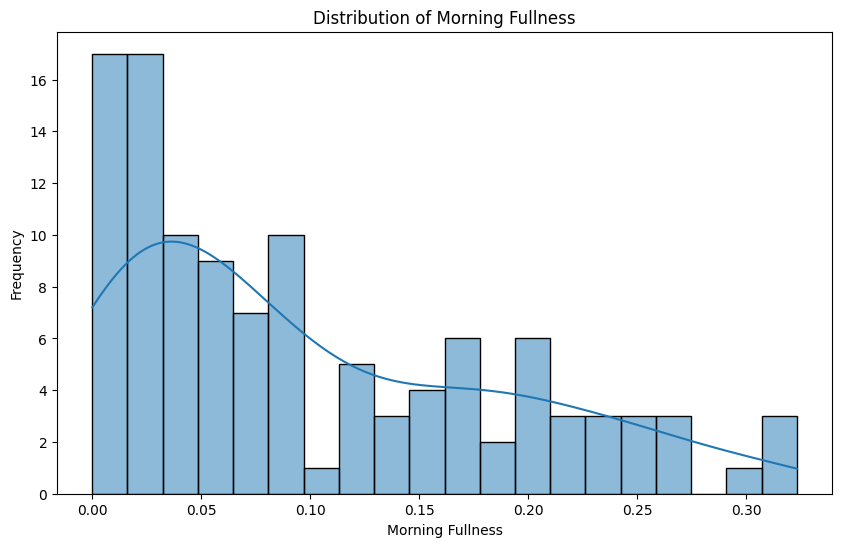

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set graphic size
plt.figure(figsize=(10, 6))

# Draw the density plot of morning fullness
sns.histplot(data=dataset_fullness_period, x='fullness_morning', bins=20, kde=True)
plt.title('Distribution of Morning Fullness')
plt.xlabel('Morning Fullness')
plt.ylabel('Frequency')

# Display graphics
plt.show()


## Ploting data to check the Distribution of datapoint

In [11]:
import folium

# Create a map object
m = folium.Map(location=[53.349805, -6.26031], zoom_start=12)

# Plot the geographical locations of bike stations
for index, row in dataset_fullness_period.iterrows():
    folium.CircleMarker(location=[row['LATITUDE'], row['LONGITUDE']], radius=5, color='blue', fill=True, fill_color='blue').add_to(m)

# Show the map


### Combine the fullness_morning and distribution of datapoints together

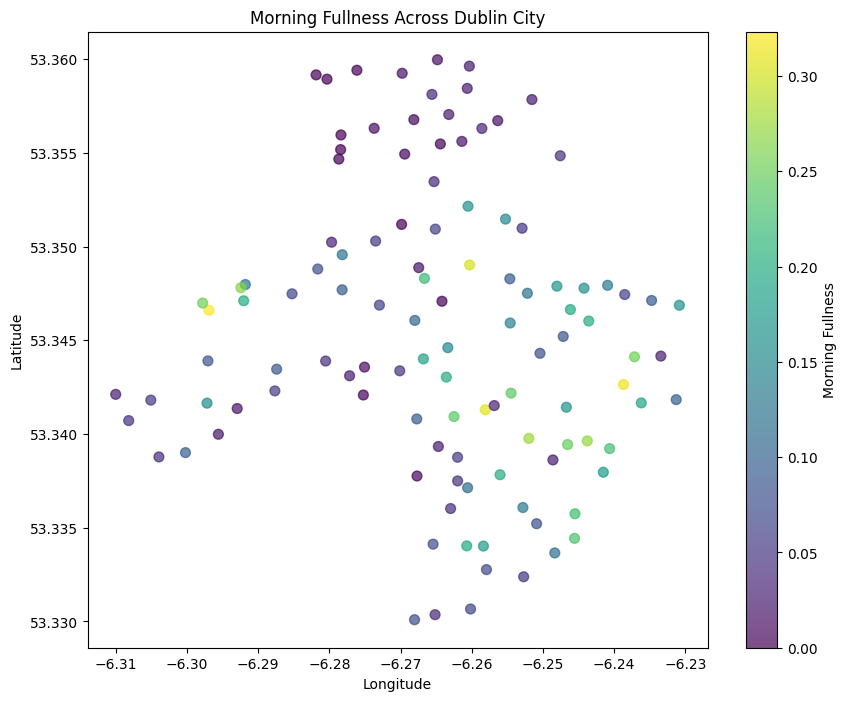

In [12]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Plot the relationship between morning fullness and geographical location
plt.scatter(dataset_fullness_period['LONGITUDE'], dataset_fullness_period['LATITUDE'], c=dataset_fullness_period['fullness_morning'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Morning Fullness')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Morning Fullness Across Dublin City')

# Show the plot
plt.show()


In [13]:
### Do the same thing to the afternoon, evening and night

##afternoon
# First, filter rows that meet the condition
filtered_data_afternoon = afternoon[afternoon['fullness'] >= threshold]

# Then, group by 'STATION ID' and calculate the number of rows satisfying the condition in each group
grouped_data_afternoon = filtered_data_afternoon.groupby('STATION_ID').size()

# Next, calculate the proportion for each 'STATION ID'
total_data_afternoon = afternoon.groupby('STATION_ID').size()
ratios_afternoon = grouped_data_afternoon / total_data_afternoon

# Merge 'ratios' with 'morning_result' based on 'STATION ID'
dataset_fullness_period = pd.merge(dataset_fullness_period, ratios_afternoon.rename('fullness_afternoon'), left_on='STATION_ID', right_index=True, how='left')

#na means there is no time slot where fullness is over the threshhold(0.9),so we replace na with 0
dataset_fullness_period['fullness_afternoon'].fillna(0, inplace=True)

##evening
# First, filter rows that meet the condition
filtered_data_evening = evening[evening['fullness'] >= threshold]

# Then, group by 'STATION ID' and calculate the number of rows satisfying the condition in each group
grouped_data_evening = filtered_data_evening.groupby('STATION_ID').size()

# Next, calculate the proportion for each 'STATION ID'
total_data_evening = evening.groupby('STATION_ID').size()
ratios_evening = grouped_data_evening / total_data_evening

# Merge 'ratios' with 'morning_result' based on 'STATION ID'
dataset_fullness_period = pd.merge(dataset_fullness_period, ratios_evening.rename('fullness_evening'), left_on='STATION_ID', right_index=True, how='left')

#na means there is no time slot where fullness is over the threshhold(0.9),so we replace na with 0
dataset_fullness_period['fullness_evening'].fillna(0, inplace=True)

##night
# First, filter rows that meet the condition
filtered_data_night = night[night['fullness'] >= threshold]

# Then, group by 'STATION ID' and calculate the number of rows satisfying the condition in each group
grouped_data_night = filtered_data_night.groupby('STATION_ID').size()

# Next, calculate the proportion for each 'STATION ID'
total_data_night = night.groupby('STATION_ID').size()
ratios_night = grouped_data_night / total_data_night

# Merge 'ratios' with 'morning_result' based on 'STATION ID'
dataset_fullness_period = pd.merge(dataset_fullness_period, ratios_night.rename('fullness_night'), left_on='STATION_ID', right_index=True, how='left')
#na means there is no time slot where fullness is over the threshhold(0.9),so we replace na with 0
dataset_fullness_period['fullness_night'].fillna(0, inplace=True)


#get the dataset we want
print(dataset_fullness_period)

     STATION_ID                               NAME  BIKE_STANDS  \
0             1                      CLARENDON ROW           31   
1             2                 BLESSINGTON STREET           20   
2             3                      BOLTON STREET           20   
3             4                       GREEK STREET           20   
4             5                   CHARLEMONT PLACE           40   
..          ...                                ...          ...   
108         111               MOUNTJOY SQUARE EAST           40   
109         112  NORTH CIRCULAR ROAD (O'CONNELL'S)           30   
110         113               MERRION SQUARE SOUTH           40   
111         114              WILTON TERRACE (PARK)           40   
112         115                   KILLARNEY STREET           30   

     AVAILABLE_BIKE_STANDS  AVAILABLE_BIKES STATUS  \
0                       14               17   Open   
1                        7               13   Open   
2                       17       

### Combine the fullness_afternoon and distribution of datapoints together

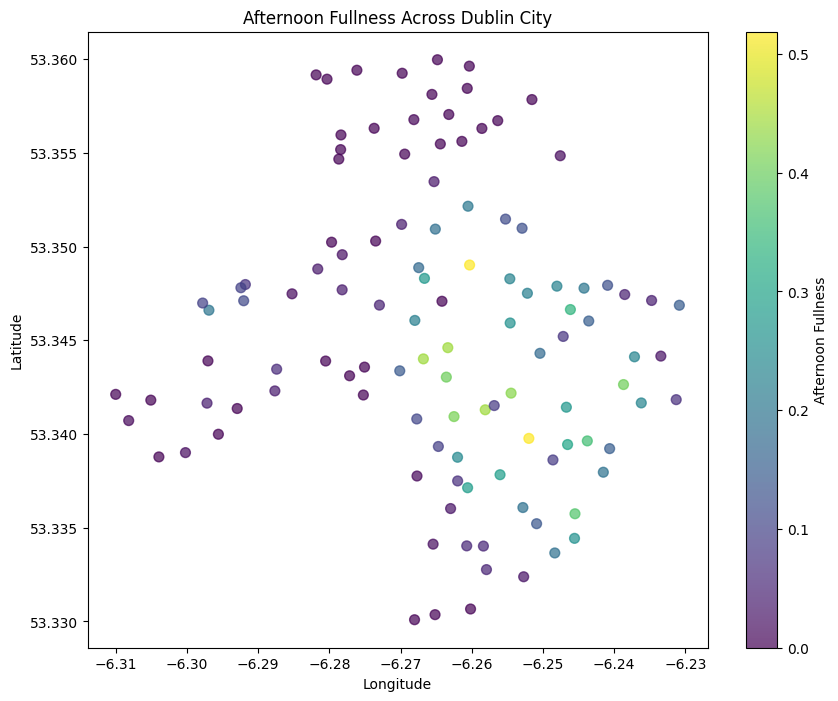

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Plot the afternoon fullness
plt.scatter(dataset_fullness_period['LONGITUDE'], dataset_fullness_period['LATITUDE'], c=dataset_fullness_period['fullness_afternoon'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Afternoon Fullness')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Afternoon Fullness Across Dublin City')

# Show the plot
plt.show()


### Combine the fullness_evening and distribution of datapoints together

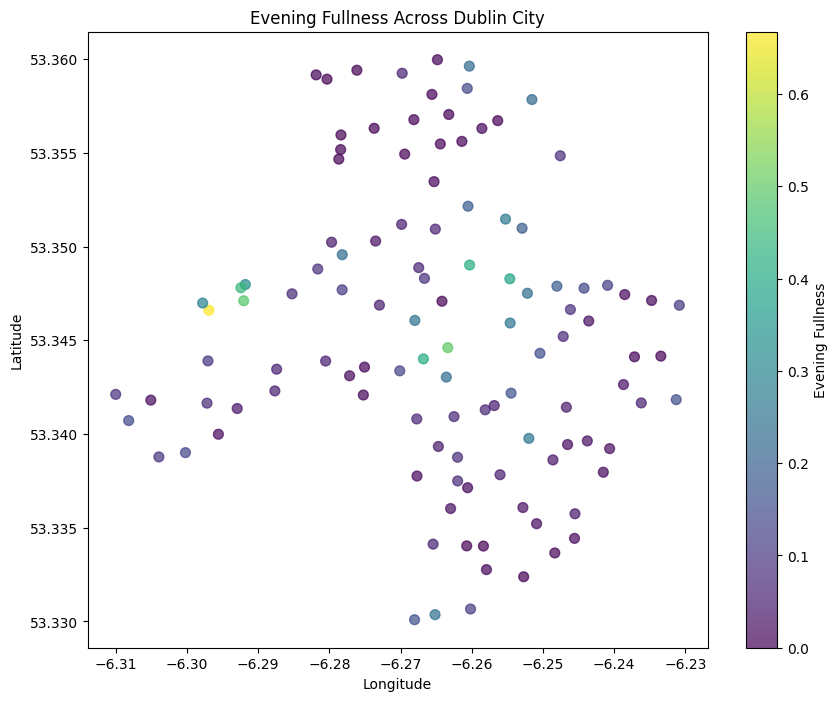

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Plot the evening fullness
plt.scatter(dataset_fullness_period['LONGITUDE'], dataset_fullness_period['LATITUDE'], c=dataset_fullness_period['fullness_evening'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Evening Fullness')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Evening Fullness Across Dublin City')

# Show the plot
plt.show()


### Combine the fullness_night and distribution of datapoints together

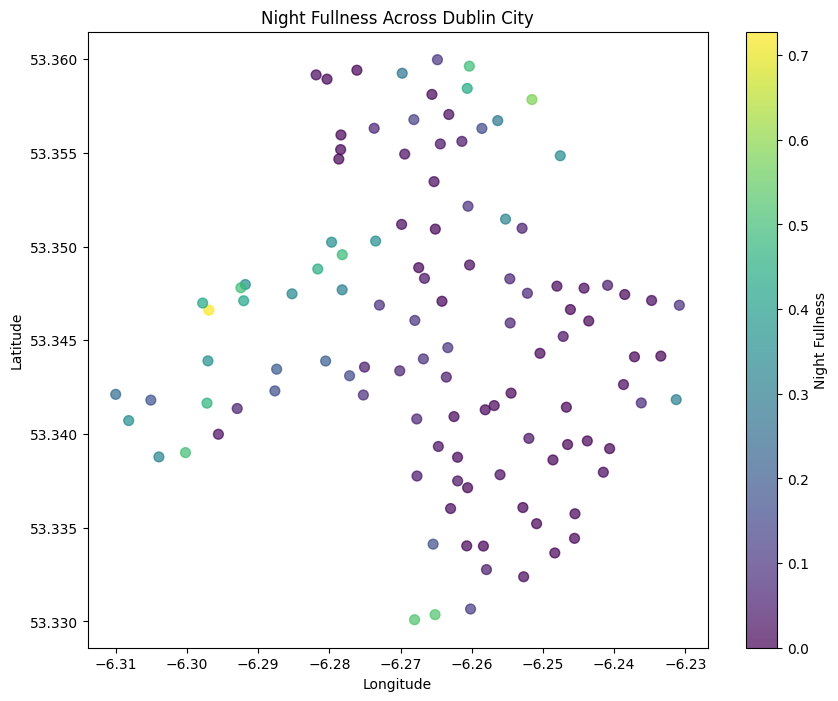

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Plot the night fullness
plt.scatter(dataset_fullness_period['LONGITUDE'], dataset_fullness_period['LATITUDE'], c=dataset_fullness_period['fullness_night'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Night Fullness')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Night Fullness Across Dublin City')

# Show the plot
plt.show()


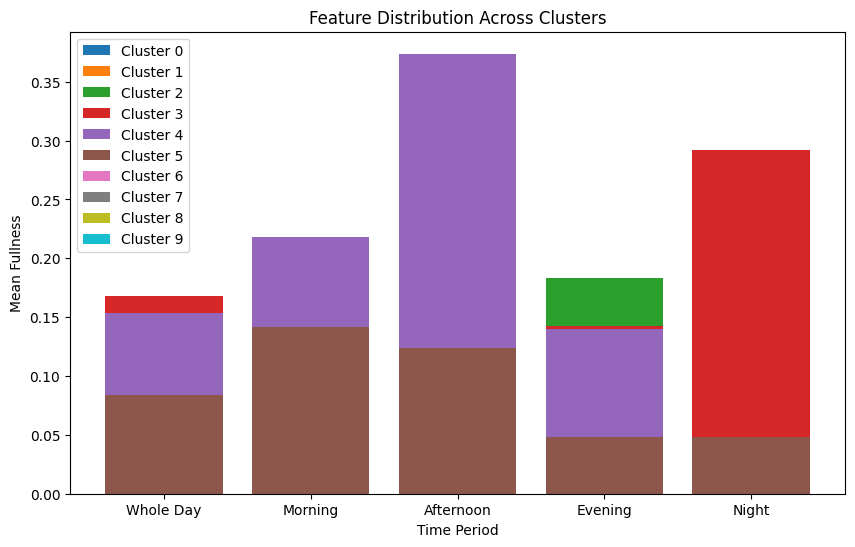

In [ ]:
import matplotlib.pyplot as plt

# Define the possible values for 'cluster_assignment'
possible_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
filtered_data_dict = {}

# Create a new figure outside the loop
plt.figure(figsize=(10, 6))

# Iterate over each possible value
for value in possible_values:
    # Filter the DataFrame to select rows where 'cluster_assignment' == value
    filtered_data = dataset_fullness_period[dataset_fullness_period['cluster_assignment'] == value]
    filtered_data_dict[value] = filtered_data

    # Plot bar chart for each feature in the cluster
    plt.bar(['Whole Day', 'Morning', 'Afternoon', 'Evening', 'Night'],
            filtered_data_dict[value][['fullness_whole_day', 'fullness_morning', 'fullness_afternoon', 'fullness_evening', 'fullness_night']].mean(),
            label=f'Cluster {value}')

plt.xlabel('Time Period')
plt.ylabel('Mean Fullness')
plt.title('Feature Distribution Across Clusters')
plt.legend()
plt.show()


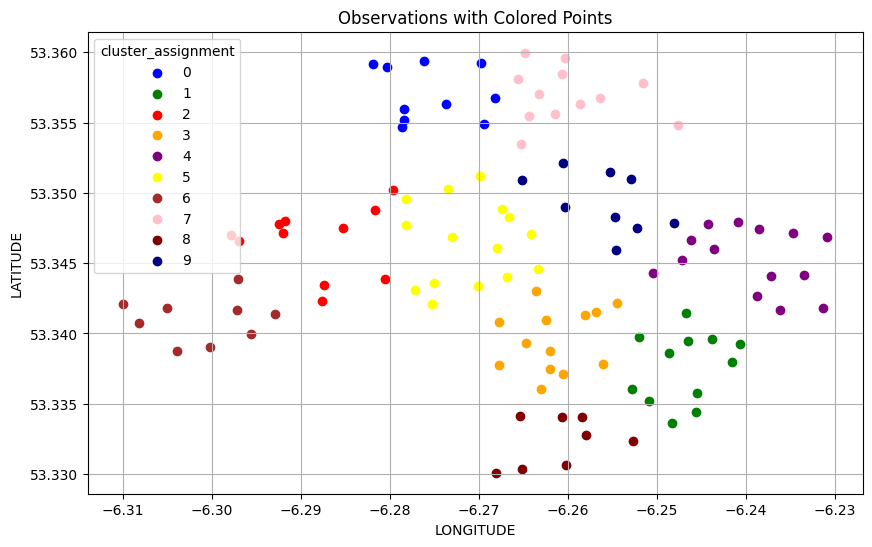

In [ ]:
import matplotlib.pyplot as plt

# Define the colors for different values
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange', 4: 'purple', 5: 'yellow', 6:'brown', 7: 'pink', 8: 'maroon', 9: 'navy'}
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Plot the observations
plt.figure(figsize=(10, 6))
for value in values:
    plt.scatter(dataset_fullness_period.loc[dataset_fullness_period['cluster_assignment'] == value, 'LONGITUDE'],
                dataset_fullness_period.loc[dataset_fullness_period['cluster_assignment'] == value, 'LATITUDE'],
                color = color_dict[value], label = value)

# Add labels and legend
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Observations with Colored Points')
plt.legend(title='cluster_assignment')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
import folium

# Create a map centered at the mean latitude and longitude of your data
map_center = [dataset_fullness_period['LATITUDE'].mean(), dataset_fullness_period['LONGITUDE'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Define the colors for different values
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange', 4: 'purple', 5: 'yellow', 6:'brown', 7: 'pink', 8: 'maroon', 9: 'navy'}


# Add markers for each data point
for index, row in dataset_fullness_period.iterrows():
    cluster_assignment = row['cluster_assignment']
    color = color_dict.get(cluster_assignment, 'gray')  # Default to gray if cluster not found in color_dict
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color
    ).add_to(mymap)

# Add a layer control for the legend
legend_html = """
     <div style="position: fixed;
                 top: 20px; right: 20px; width: 120px; height: 280px;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white;
                 opacity: 0.6;
                 ">
     &nbsp;<b>Cluster Legend</b><br>
     """
for cluster, color in color_dict.items():
    legend_html += f"&nbsp;<div style='width:20px;height:20px;background-color:{color};display:inline-block;'></div>&nbsp;Cluster {cluster}<br>"

legend_html += """
      </div>
     """
legend = folium.Html(legend_html, script=True)
mymap.get_root().html.add_child(legend)

# Display the map
mymap


# 3.Cluster

 We cluster based on fullness in the morning longitude and latitiude




In [15]:
# Custer based on features we want

# Selection feature
cluster_features = ['LATITUDE', 'LONGITUDE', 'fullness_afternoon']

# Data preprocessing
X = dataset_fullness_period[cluster_features].dropna()  # Delete missing values
scaler = StandardScaler()  # Standardized feature
X_scaled = scaler.fit_transform(X)

# Cluster analysis
# I will try 5 clusters to start
kmeans_morn = KMeans(n_clusters = 5, random_state=420)
kmeans_morn.fit(X_scaled)
dataset_fullness_period['cluster_assignment'] = kmeans_morn.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Use Calinski Crieterion to Determine the Optimal Number of Clusters

In [ ]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Assuming dataset_fullness_period and cluster_features are defined as in your question

# Data preprocessing
X = dataset_fullness_period[cluster_features].dropna()  # Delete missing values
scaler = StandardScaler()  # Standardized feature
X_scaled = scaler.fit_transform(X)

# Range of possible clusters
range_n_clusters = range(2, 6)  # for example, from 2 to 6

# Initialize an empty list to store CH scores
ch_scores = []

# Iterate over the range of cluster numbers
for n_clusters in range_n_clusters:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=33)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Calculate the CH score
    ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
    ch_scores.append(ch_score)
    print(f'Number of clusters: {n_clusters}, CH score: {ch_score}')

# Find the optimal number of clusters based on the highest CH score
optimal_n_clusters = range_n_clusters[np.argmax(ch_scores)]
print(f'Optimal number of clusters: {optimal_n_clusters}')

## The culstering result by table

In [16]:
# Define the possible values for 'cluster_assignment'
possible_values = [0,1,2,3,4,5]
data_dict={}

# Temporarily adjust Pandas display options
with pd.option_context('display.max_rows', None):  # Set to None to display all rows
    for value in possible_values:
        # Filter the DataFrame to select rows where 'cluster_assignment' == value
        filtered_data = dataset_fullness_period[dataset_fullness_period['cluster_assignment'] == value]

        # Sort the values of the 'fullness_morning' column
        sor_morn = filtered_data[['LATITUDE', 'LONGITUDE','fullness_afternoon','STATION_ID','BIKE_STANDS','fullness_whole_day','fullness_morning', 'fullness_night', 'fullness_evening', 'cluster_assignment', 'ADDRESS']].sort_values('fullness_afternoon')
        data_dict[value]=sor_morn

        # Print the sorted values for 'fullness_morning' column
        print(f"Values for 'fullness_evening' column where 'cluster_assignment' == {value}, sorted:")
        print(data_dict[value])
        #print()  # Add a newline for clarity

Values for 'fullness_evening' column where 'cluster_assignment' == 0, sorted:
     LATITUDE  LONGITUDE  fullness_afternoon  STATION_ID  BIKE_STANDS  \
88  53.344154  -6.233451            0.024188          90           40   
64  53.347122  -6.234749            0.041465          66           40   
63  53.347439  -6.238523            0.043884          65           40   
89  53.341831  -6.231291            0.068072          91           30   
62  53.345203  -6.247163            0.075674          64           40   
43  53.351463  -6.255265            0.116102          45           30   
47  53.347931  -6.240928            0.124395          49           40   
36  53.350975  -6.252940            0.125432          38           40   
5   53.343369  -6.270120            0.140981           6           20   
65  53.346867  -6.230852            0.147547          67           40   
56  53.339218  -6.240642            0.149965          58           40   
60  53.346027  -6.243576            0.151348  

## The culstering result by plot

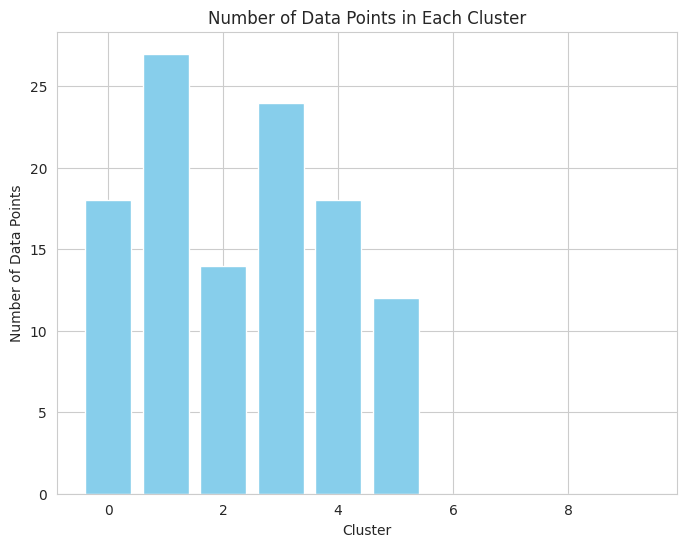

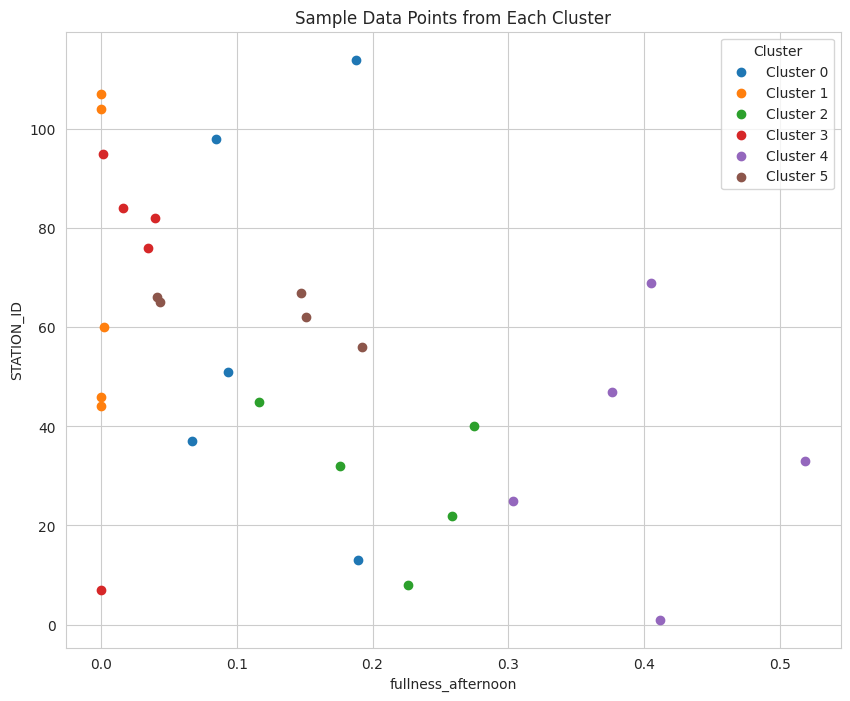

In [ ]:
import matplotlib.pyplot as plt

# Count the number of data points in each cluster
cluster_counts = [len(data_dict.get(key, [])) for key in possible_values]

# Ensure that cluster_counts has the same length as possible_values
cluster_counts += [0] * (len(possible_values) - len(cluster_counts))

# Plot the bar chart for cluster counts
plt.figure(figsize=(8, 6))
plt.bar(possible_values, cluster_counts, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in Each Cluster')
plt.grid(True)
plt.show()

# Plot some sample data points for each cluster
plt.figure(figsize=(10, 8))
for cluster in possible_values:
    if cluster in data_dict:
        sample_data = data_dict[cluster].sample(min(5, len(data_dict[cluster])))  # Sample up to 5 data points from each cluster
        plt.scatter(sample_data['fullness_afternoon'], sample_data['STATION_ID'], label=f'Cluster {cluster}')

plt.xlabel('fullness_afternoon')
plt.ylabel('STATION_ID')
plt.title('Sample Data Points from Each Cluster')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


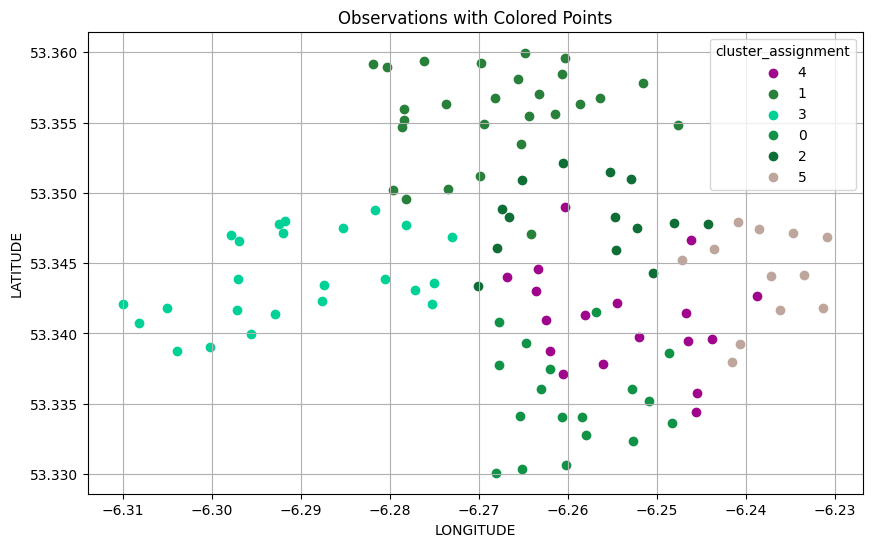

In [ ]:
color_dict = create_color_dict(n)

import matplotlib.pyplot as plt


# Plot the observations
plt.figure(figsize=(10, 6))
for value in dataset_fullness_period['cluster_assignment'].unique():
    plt.scatter(dataset_fullness_period.loc[dataset_fullness_period['cluster_assignment'] == value, 'LONGITUDE'],
                dataset_fullness_period.loc[dataset_fullness_period['cluster_assignment'] == value, 'LATITUDE'],
                color=color_dict[value], label=value)

# Add labels and legend
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Observations with Colored Points')
plt.legend(title='cluster_assignment')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
import folium

# Create a Folium map centered at the mean latitude and longitude of your data
map_center = [dataset_fullness_period['LATITUDE'].mean(), dataset_fullness_period['LONGITUDE'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Define new colors for different clusters
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange', 4: 'purple', 5: 'yellow', 6: 'brown'}

# Add markers for each cluster
for value in dataset_fullness_period['cluster_assignment'].unique():
    cluster_data = dataset_fullness_period[dataset_fullness_period['cluster_assignment'] == value]
    color = color_dict.get(value, 'gray')
    for index, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color
        ).add_to(mymap)

# Add labels to the map legend in the top-right corner
legend_html = """
<div style="position: fixed;
             top: 20px; right: 20px; width: 120px; height: 190px;
             border:2px solid grey; z-index:9999; font-size:14px;
             background-color: white;
             opacity: 0.6;
             ">
&nbsp;<b>Cluster Legend</b><br>
"""
for value in sorted(dataset_fullness_period['cluster_assignment'].unique()):
    color = color_dict.get(value, 'gray')
    legend_html += f"&nbsp;<div style='width:20px;height:20px;background-color:{color};display:inline-block;'></div>&nbsp;Cluster {value}<br>"

legend_html += """
  </div>
"""
legend = folium.Html(legend_html, script=True)
mymap.get_root().html.add_child(legend)

# Display the map
mymap


## Plot the distribution between BIKE_STANDS VS fullness in certain cluster

We See a strong relationship between number of stands and fullness in this cluster across all time periods.

Text(0, 0.5, 'fullness_mon')

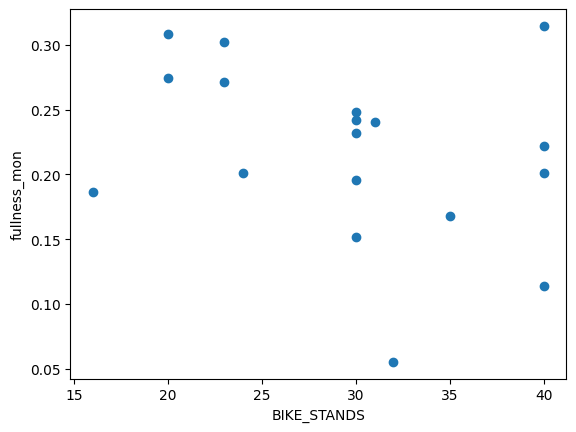

In [ ]:
#BIKE_STANDS VS fullness_whole_day
plt.scatter(data_dict[4].BIKE_STANDS ,data_dict[4].fullness_morning)
plt.xlabel('BIKE_STANDS')
plt.ylabel('fullness_mon')

Text(0, 0.5, 'fullness_mon')

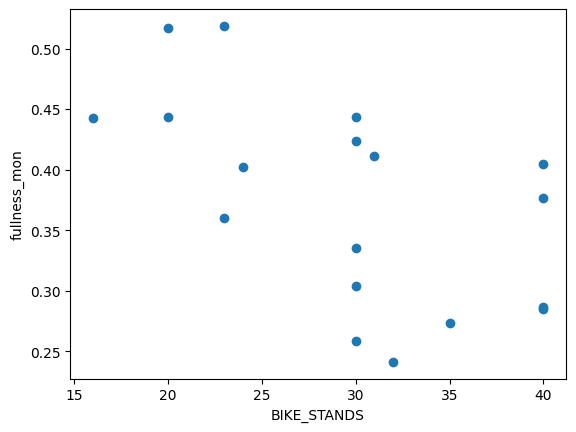

In [ ]:
#BIKE_STANDS VS fullness_whole_day
plt.scatter(data_dict[4].BIKE_STANDS ,data_dict[4].fullness_afternoon)
plt.xlabel('BIKE_STANDS')
plt.ylabel('fullness_mon')

Text(0, 0.5, 'fullness_mon')

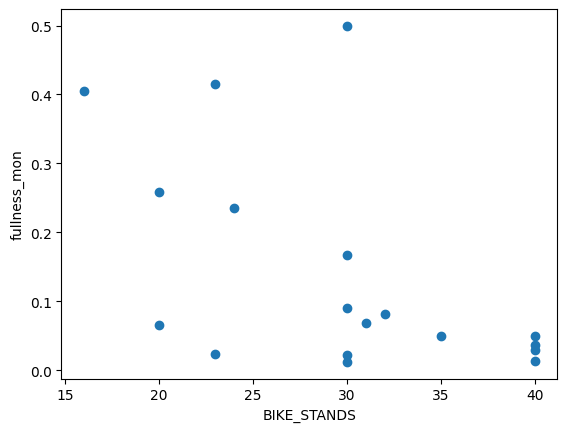

In [ ]:
#BIKE_STANDS VS fullness_whole_day
plt.scatter(data_dict[4].BIKE_STANDS ,data_dict[4].fullness_evening)
plt.xlabel('BIKE_STANDS')
plt.ylabel('fullness_mon')

Text(0, 0.5, 'fullness_')

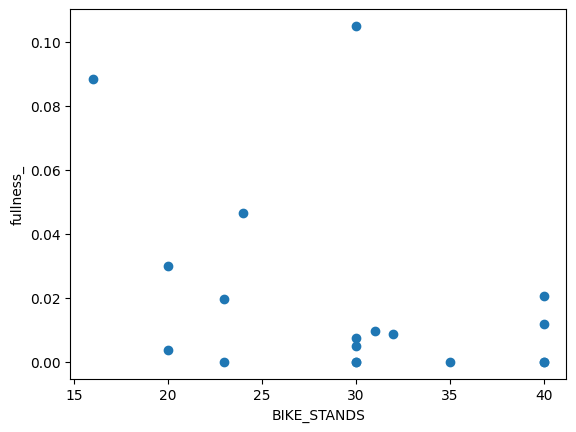

In [ ]:
#BIKE_STANDS VS fullness_whole_day
plt.scatter(data_dict[4].BIKE_STANDS ,data_dict[4].fullness_night)
plt.xlabel('BIKE_STANDS')
plt.ylabel('fullness_')

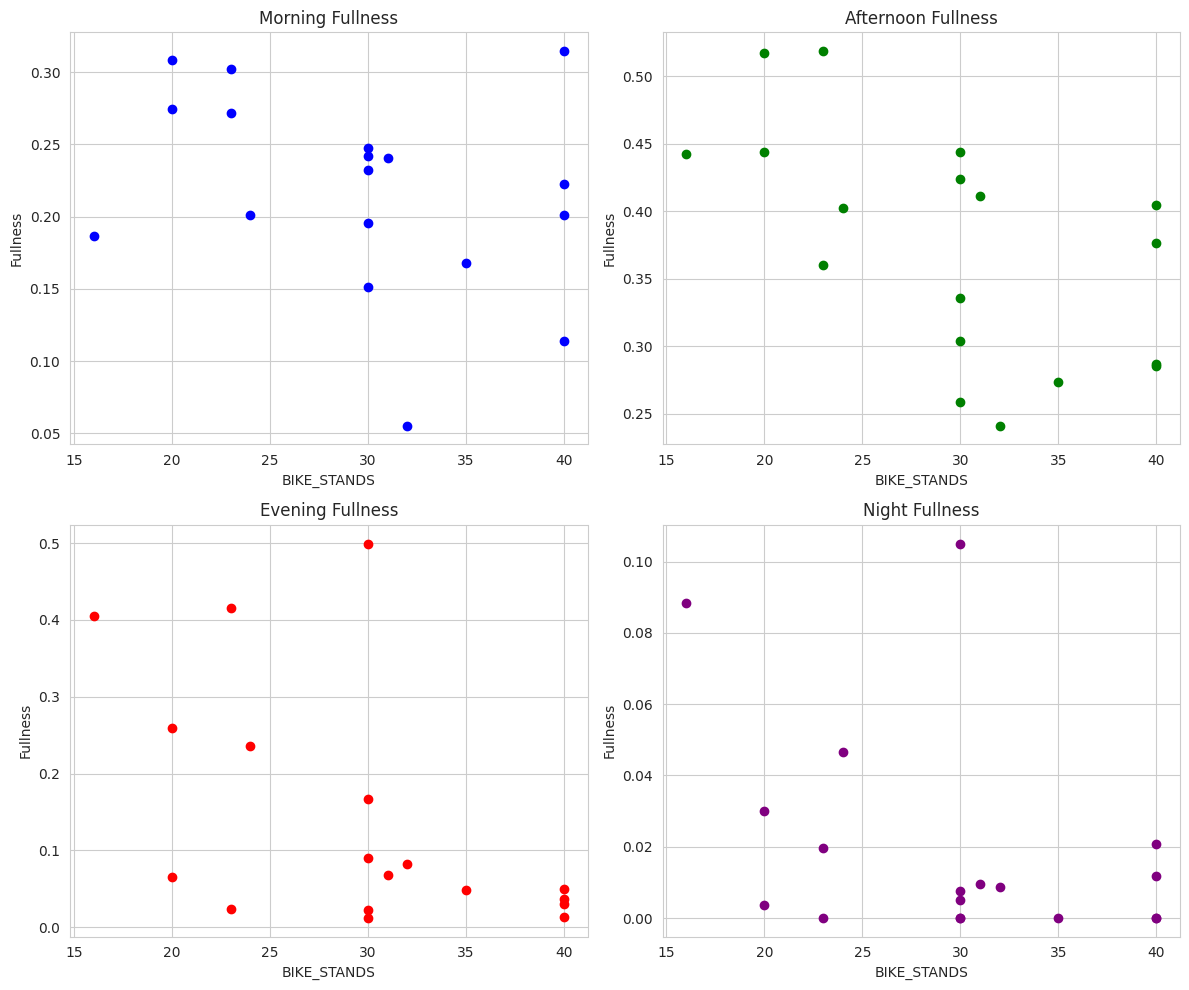

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot 1: BIKE_STANDS vs. fullness_morning
axs[0, 0].scatter(data_dict[4].BIKE_STANDS, data_dict[4].fullness_morning, color='blue')
axs[0, 0].set_title('Morning Fullness')
axs[0, 0].set_xlabel('BIKE_STANDS')
axs[0, 0].set_ylabel('Fullness')

# Scatter plot 2: BIKE_STANDS vs. fullness_afternoon
axs[0, 1].scatter(data_dict[4].BIKE_STANDS, data_dict[4].fullness_afternoon, color='green')
axs[0, 1].set_title('Afternoon Fullness')
axs[0, 1].set_xlabel('BIKE_STANDS')
axs[0, 1].set_ylabel('Fullness')

# Scatter plot 3: BIKE_STANDS vs. fullness_evening
axs[1, 0].scatter(data_dict[4].BIKE_STANDS, data_dict[4].fullness_evening, color='red')
axs[1, 0].set_title('Evening Fullness')
axs[1, 0].set_xlabel('BIKE_STANDS')
axs[1, 0].set_ylabel('Fullness')

# Scatter plot 4: BIKE_STANDS vs. fullness_night
axs[1, 1].scatter(data_dict[4].BIKE_STANDS, data_dict[4].fullness_night, color='purple')
axs[1, 1].set_title('Night Fullness')
axs[1, 1].set_xlabel('BIKE_STANDS')
axs[1, 1].set_ylabel('Fullness')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# 4.Regression

## Run regression between number of stands in a cluster and fullness of each period

In [ ]:
from sklearn.linear_model import LinearRegression
#Again scikit-learn library to help us

In [ ]:
#group 4, fullness_morning
#Make it ready for regression, as a DataFrame
BIKE_STANDSVSfullness_morning =pd.DataFrame(data_dict[4], columns = ["BIKE_STANDS", "fullness_morning"])
print(BIKE_STANDSVSfullness_morning)
type(BIKE_STANDSVSfullness_morning)

    BIKE_STANDS  fullness_morning
50           32          0.055375
18           30          0.232201
61           35          0.167985
51           40          0.114007
34           40          0.201256
23           30          0.247790
97           30          0.195440
55           23          0.271522
45           40          0.222196
8            24          0.201024
67           40          0.314565
0            31          0.240810
19           30          0.241740
9            16          0.186366
13           30          0.151466
25           20          0.308516
24           20          0.274546
31           23          0.302234


pandas.core.frame.DataFrame

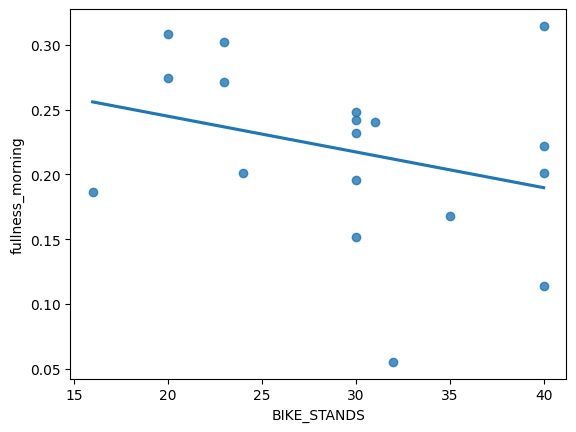

Mean Squared Error, training set: 866.748405078677
Mean Squared Error, testing set: 1086.1545358668516


In [ ]:

#group 4, fullness_morning
#Make it ready for regression, as a DataFrame
BIKE_STANDSVSfullness_morning =pd.DataFrame(data_dict[4], columns = ["BIKE_STANDS", "fullness_morning"])

#We split the data into a training and testing part
#for both the 'Engine size' (as X) and the 'Price' (as y, our answers)
#With a randomisation of the dataset
BS_train, BS_test, FM_train, FM_test = train_test_split(BIKE_STANDSVSfullness_morning.fullness_morning, BIKE_STANDSVSfullness_morning.BIKE_STANDS, test_size=0.2, random_state=42)

#Adapting to array format (not important, formatting to adapt to a different library)
FM_train_arr = FM_train.array.to_numpy().reshape(-1,1)
FM_test_arr = FM_test.array.to_numpy().reshape(-1,1)
BS_train_arr = BS_train.array.to_numpy().reshape(-1,1)
BS_test_arr = BS_test.array.to_numpy().reshape(-1,1)

# Linear regression
reg_morning = LinearRegression().fit(FM_train_arr, BS_train_arr)

#Predict price based on engine size
fitted_train_FM = reg_morning.predict(BS_train_arr)
fitted_test_FM = reg_morning.predict(BS_test_arr)

#Visualisation
# Seaborn library is used to easily visualise a dataset and its summarising models
import seaborn as sns
sns.regplot(x=BIKE_STANDSVSfullness_morning.BIKE_STANDS,y= BIKE_STANDSVSfullness_morning.fullness_morning,ci=None)
plt.show()

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(FM_train, fitted_train_FM)
print('Mean Squared Error, training set:', MSE)

MSE = mean_squared_error(FM_test, fitted_test_FM)
print('Mean Squared Error, testing set:', MSE)

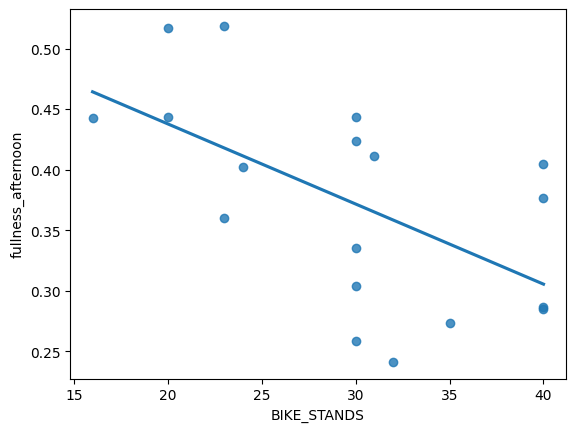

Mean Squared Error, training set: 850.4626204304196
Mean Squared Error, testing set: 1067.368998315038


In [ ]:
#group 4, fullness_afternoon
#Make it ready for regression, as a DataFrame
BIKE_STANDSVSfullness_afternoon =pd.DataFrame(data_dict[4], columns = ["BIKE_STANDS", "fullness_afternoon"])

#We split the data into a training and testing part
#for both the 'Engine size' (as X) and the 'Price' (as y, our answers)
#With a randomisation of the dataset
BS_train, BS_test, FA_train, FA_test = train_test_split(data_dict[4].fullness_afternoon, data_dict[4].BIKE_STANDS, test_size=0.2, random_state=42)

#Adapting to array format (not important, formatting to adapt to a different library)
FA_train = FA_train.array.to_numpy().reshape(-1,1)
FA_test = FA_test.array.to_numpy().reshape(-1,1)
BS_train = BS_train.array.to_numpy().reshape(-1,1)
BS_test = BS_test.array.to_numpy().reshape(-1,1)

#Linear regression
#Again store results (weights) in the 'reg' object
reg_afternoon = LinearRegression().fit(FA_train, BS_train)

#Predict
fitted_train_FA = reg_afternoon.predict(BS_train)
fitted_test_FA = reg_afternoon.predict(BS_test)

#Visualisation
# Seaborn library is used to easily visualise a dataset and its summarising models
import seaborn as sns
sns.regplot(x=BIKE_STANDSVSfullness_afternoon.BIKE_STANDS,y= BIKE_STANDSVSfullness_afternoon.fullness_afternoon,ci=None)
plt.show()

MSE = mean_squared_error(FA_train, fitted_train_FA)
print('Mean Squared Error, training set:', MSE)

MSE = mean_squared_error(FA_test, fitted_test_FA)
print('Mean Squared Error, testing set:', MSE)

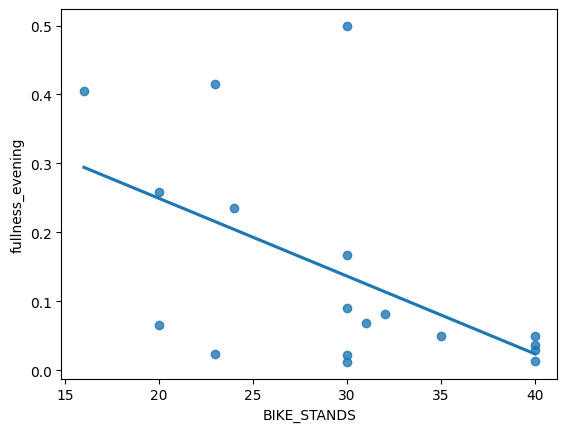

Mean Squared Error, training set: 856.5361820226407
Mean Squared Error, testing set: 1074.3259172106118


In [ ]:
#group 4, fullness_evening
#Make it ready for regression, as a DataFrame
BIKE_STANDSVSfullness_evening =pd.DataFrame(data_dict[4], columns = ["BIKE_STANDS", "fullness_evening"])

#We split the data into a training and testing part
#for both the 'Engine size' (as X) and the 'Price' (as y, our answers)
#With a randomisation of the dataset
BS_train, BS_test, FE_train, FE_test = train_test_split(data_dict[4].fullness_evening, data_dict[4].BIKE_STANDS, test_size=0.2, random_state=42)

#Adapting to array format (not important, formatting to adapt to a different library)
FE_train = FE_train.array.to_numpy().reshape(-1,1)
FE_test = FE_test.array.to_numpy().reshape(-1,1)
BS_train = BS_train.array.to_numpy().reshape(-1,1)
BS_test = BS_test.array.to_numpy().reshape(-1,1)

#Linear regression
#Again store results (weights) in the 'reg' object
reg_evening = LinearRegression().fit(FE_train, BS_train)

#Predict
fitted_train_FE = reg_evening.predict(BS_train)
fitted_test_FE = reg_evening.predict(BS_test)

#Visualisation
# Seaborn library is used to easily visualise a dataset and its summarising models
import seaborn as sns
sns.regplot(x=BIKE_STANDSVSfullness_evening.BIKE_STANDS,y= BIKE_STANDSVSfullness_evening.fullness_evening,ci=None)
plt.show()

MSE = mean_squared_error(FE_train, fitted_train_FE)
print('Mean Squared Error, training set:', MSE)

MSE = mean_squared_error(FE_test, fitted_test_FE)
print('Mean Squared Error, testing set:', MSE)

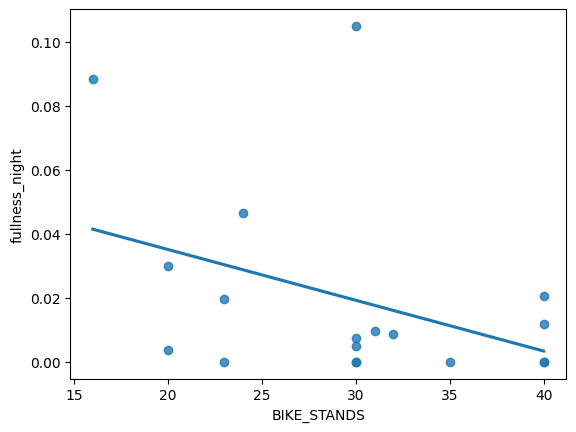

Mean Squared Error, training set: 880.1949556076839
Mean Squared Error, testing set: 1101.6247013215986


In [ ]:
#group 4, fullness_night
#Make it ready for regression, as a DataFrame
BIKE_STANDSVSfullness_night =pd.DataFrame(data_dict[4], columns = ["BIKE_STANDS", "fullness_night"])

#We split the data into a training and testing part
#for both the 'Engine size' (as X) and the 'Price' (as y, our answers)
#With a randomisation of the dataset
BS_train, BS_test, FN_train, FN_test = train_test_split(data_dict[4].fullness_night, data_dict[4].BIKE_STANDS, test_size=0.2, random_state=42)

#Adapting to array format (not important, formatting to adapt to a different library)
FN_train = FN_train.array.to_numpy().reshape(-1,1)
FN_test = FN_test.array.to_numpy().reshape(-1,1)
BS_train = BS_train.array.to_numpy().reshape(-1,1)
BS_test = BS_test.array.to_numpy().reshape(-1,1)

#Linear regression
#Again store results (weights) in the 'reg' object
reg_night = LinearRegression().fit(FN_train, BS_train)

#Predict
fitted_train_FN = reg_night.predict(BS_train)
fitted_test_FN = reg_night.predict(BS_test)

#Visualisation
# Seaborn library is used to easily visualise a dataset and its summarising models
import seaborn as sns
sns.regplot(x=BIKE_STANDSVSfullness_night.BIKE_STANDS,y= BIKE_STANDSVSfullness_night.fullness_night,ci=None)
plt.show()

MSE = mean_squared_error(FE_train, fitted_train_FN)
print('Mean Squared Error, training set:', MSE)

MSE = mean_squared_error(FE_test, fitted_test_FN)
print('Mean Squared Error, testing set:', MSE)

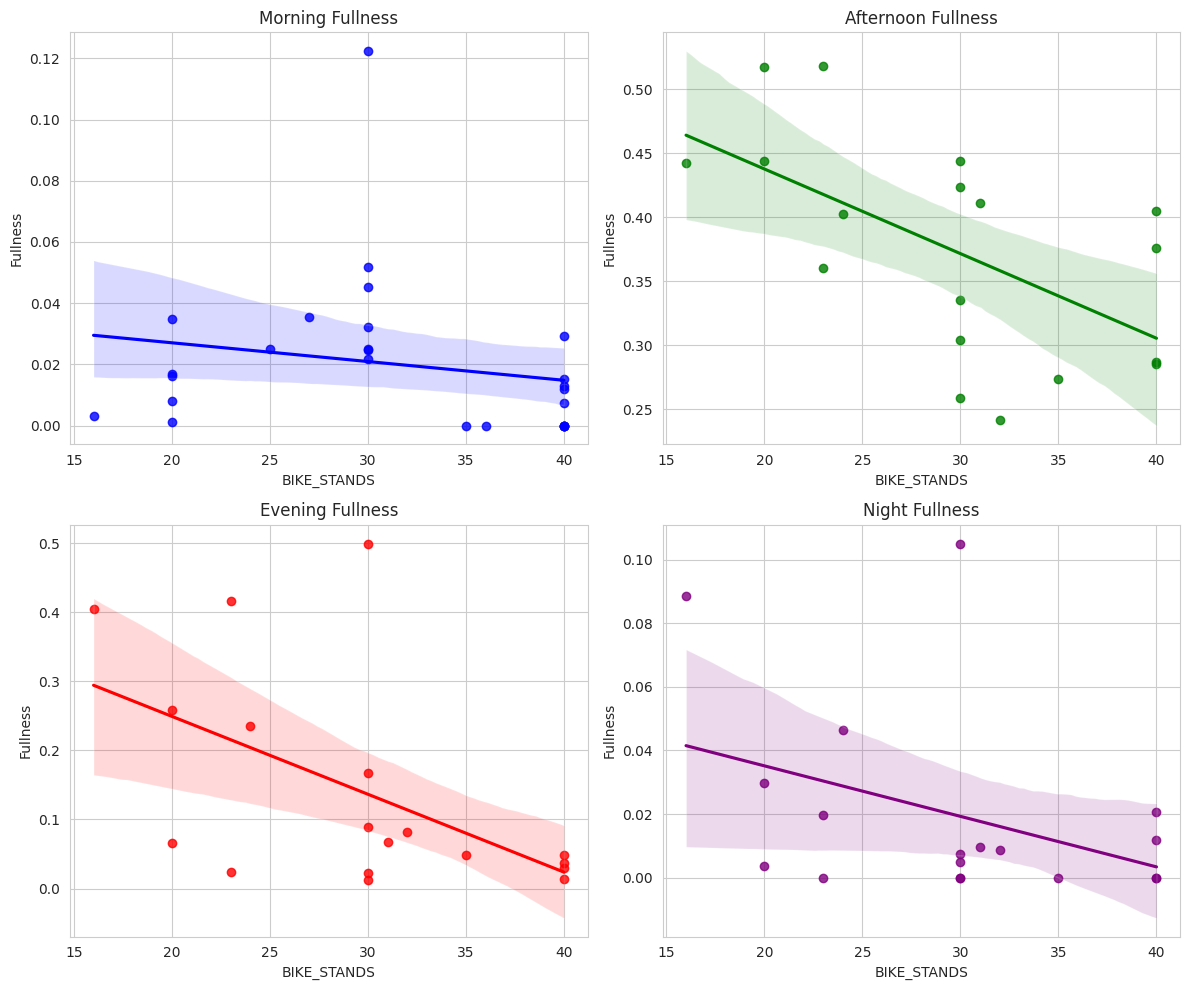

In [ ]:
import seaborn as sns

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot 1: BIKE_STANDS vs. fullness_morning
sns.regplot(x=BIKE_STANDSVSfullness_morning.BIKE_STANDS, y=BIKE_STANDSVSfullness_morning.fullness_morning, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Morning Fullness')
axs[0, 0].set_xlabel('BIKE_STANDS')
axs[0, 0].set_ylabel('Fullness')

# Scatter plot 2: BIKE_STANDS vs. fullness_afternoon
sns.regplot(x=BIKE_STANDSVSfullness_afternoon.BIKE_STANDS, y=BIKE_STANDSVSfullness_afternoon.fullness_afternoon, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Afternoon Fullness')
axs[0, 1].set_xlabel('BIKE_STANDS')
axs[0, 1].set_ylabel('Fullness')

# Scatter plot 3: BIKE_STANDS vs. fullness_evening
sns.regplot(x=BIKE_STANDSVSfullness_evening.BIKE_STANDS, y=BIKE_STANDSVSfullness_evening.fullness_evening, ax=axs[1, 0], color='red')
axs[1, 0].set_title('Evening Fullness')
axs[1, 0].set_xlabel('BIKE_STANDS')
axs[1, 0].set_ylabel('Fullness')

# Scatter plot 4: BIKE_STANDS vs. fullness_night
sns.regplot(x=BIKE_STANDSVSfullness_night.BIKE_STANDS, y=BIKE_STANDSVSfullness_night.fullness_night, ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Night Fullness')
axs[1, 1].set_xlabel('BIKE_STANDS')
axs[1, 1].set_ylabel('Fullness')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Subset the most full stations and use the regression to predict the result after we add 5 stands to each station

In [ ]:
most_full=data_dict[4].tail(5)

most_full['new_stands'] = most_full['BIKE_STANDS'] + 5

new_stand=most_full['new_stands'].to_numpy().reshape(-1,1)

new_fullness_morning = reg_morning.predict(new_stand)
new_fullness_afternoon = reg_afternoon.predict(new_stand)
new_fullness_evening = reg_evening.predict(new_stand)
new_fullness_night = reg_night.predict(new_stand)

# print(new_stand)
# print(new_fullness_morning)
# print(new_fullness_afternoon)
# print(new_fullness_evening)
# print(new_fullness_night)



most_full['new_fullness_morning'] = new_fullness_morning
most_full['new_fullness_afternoon'] = new_fullness_afternoon
most_full['new_fullness_evening'] = new_fullness_evening
most_full['new_fullness_night'] = new_fullness_night

print(most_full)


    fullness_afternoon  STATION_ID  BIKE_STANDS  fullness_whole_day  \
9             0.442294          10           16            0.238450   
13            0.443677          14           30            0.256157   
25            0.443677          27           20            0.165830   
24            0.517277          26           20            0.220165   
31            0.518659          33           23            0.256446   

    fullness_morning  fullness_night  fullness_evening  cluster_assignment  \
9           0.186366        0.088403          0.404984                   4   
13          0.151466        0.105036          0.499452                   4   
25          0.308516        0.003696          0.065991                   4   
24          0.274546        0.029878          0.259036                   4   
31          0.302234        0.019714          0.415663                   4   

                              ADDRESS  new_stands  new_fullness_morning  \
9                         Dam

<ipython-input-57-8b8f2e9c31a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_full['new_stands'] = most_full['BIKE_STANDS'] + 5
<ipython-input-57-8b8f2e9c31a0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_full['new_fullness_morning'] = new_fullness_morning
<ipython-input-57-8b8f2e9c31a0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Plot the original fullness vs augumented fullness

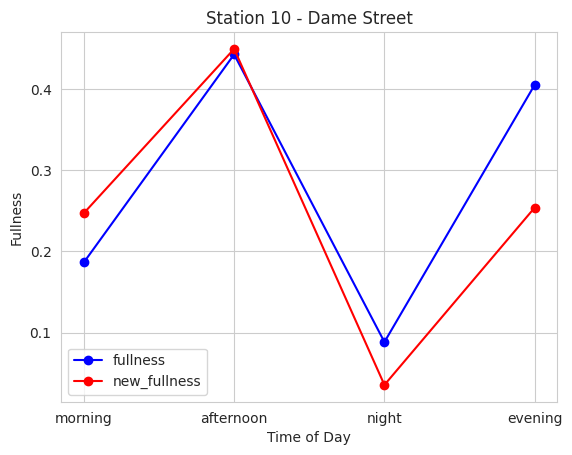

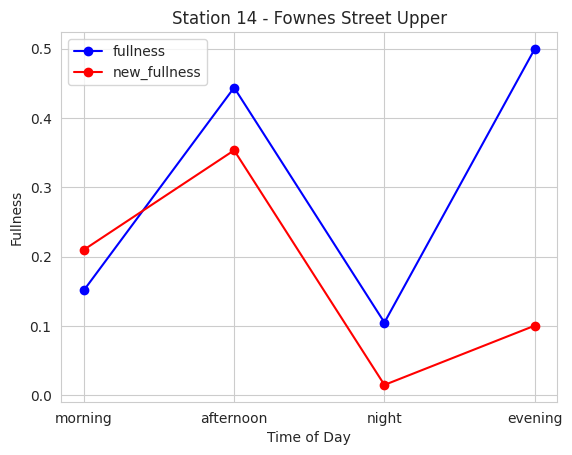

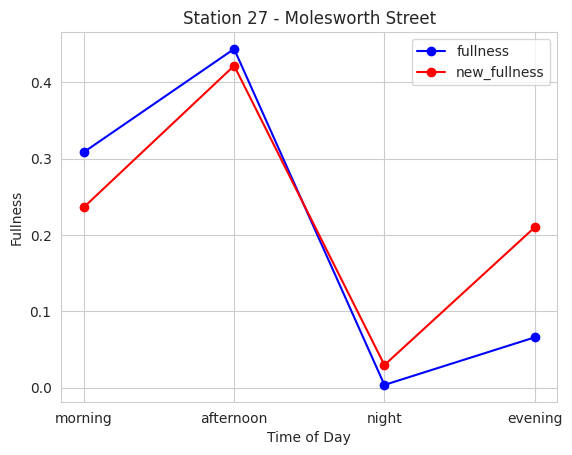

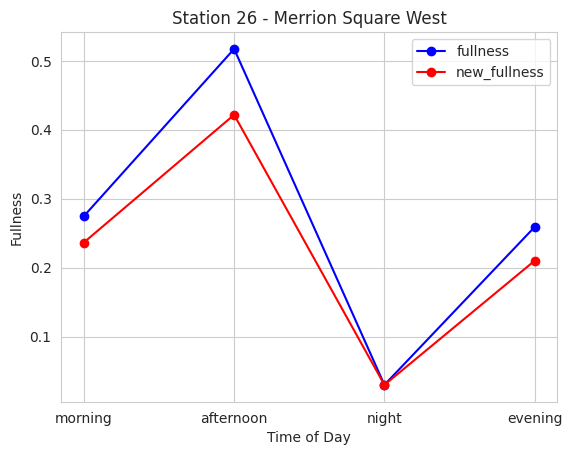

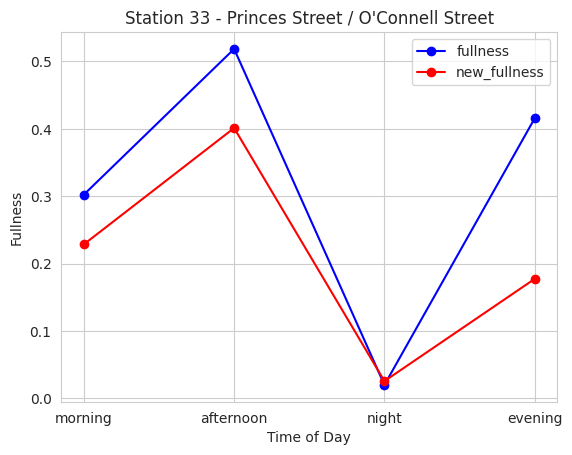

In [ ]:
for index, row in most_full.iterrows():
    plt.figure()
    plt.plot(['morning', 'afternoon', 'night', 'evening'], [row['fullness_morning'], row['fullness_afternoon'], row['fullness_night'], row['fullness_evening']], label='fullness', color='blue', marker='o')
    plt.plot(['morning', 'afternoon', 'night', 'evening'], [row['new_fullness_morning'], row['new_fullness_afternoon'], row['new_fullness_night'], row['new_fullness_evening']], label='new_fullness', color='red', marker='o')
    plt.xlabel('Time of Day')
    plt.ylabel('Fullness')
    plt.title(f'Station {row["STATION_ID"]} - {row["ADDRESS"]}')
    plt.legend()

plt.show()

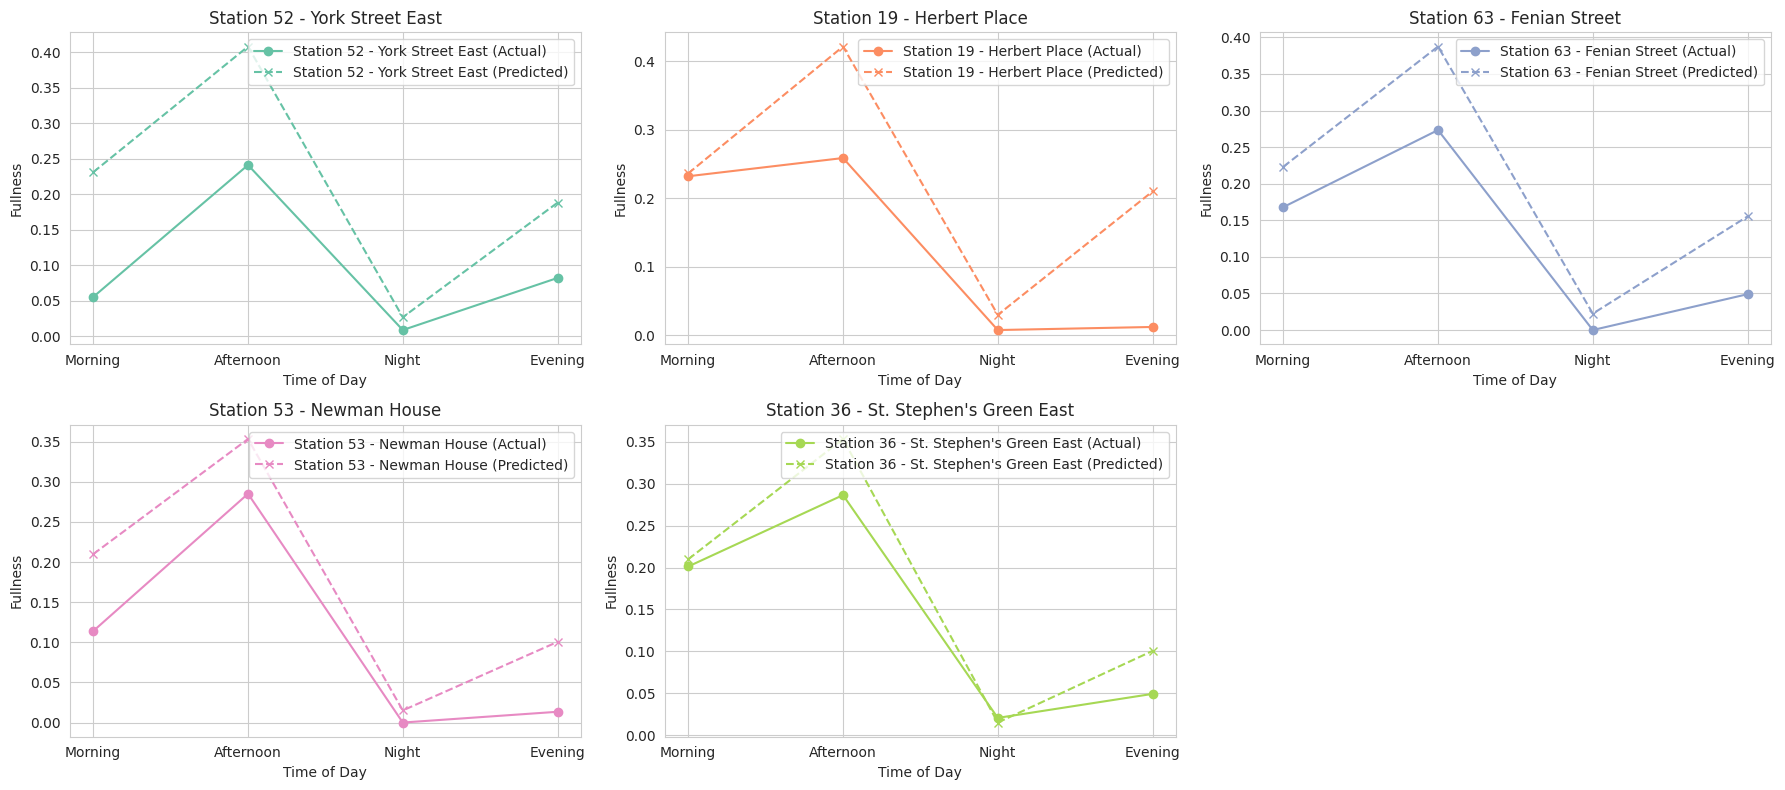

In [ ]:
import seaborn as sns

# Set a color palette for better visualization
palette = sns.color_palette("Set1")

# Create a figure and axis object for subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Plot the fullness trends for selected stations
for i, (index, row) in enumerate(most_full.iterrows()):
    color_index = i % len(palette)  # Get the color index within the palette
    axs[i].plot(['Morning', 'Afternoon', 'Night', 'Evening'],
                [row['fullness_morning'], row['fullness_afternoon'], row['fullness_night'], row['fullness_evening']],
                label=f'Station {row["STATION_ID"]} - {row["ADDRESS"]} (Actual)',
                color=palette[color_index], marker='o')
    axs[i].plot(['Morning', 'Afternoon', 'Night', 'Evening'],
                [row['new_fullness_morning'], row['new_fullness_afternoon'], row['new_fullness_night'], row['new_fullness_evening']],
                linestyle='--',
                label=f'Station {row["STATION_ID"]} - {row["ADDRESS"]} (Predicted)',
                color=palette[color_index], marker='x')  # Dashed line for predicted values

    axs[i].set_xlabel('Time of Day')
    axs[i].set_ylabel('Fullness')
    axs[i].set_title(f'Station {row["STATION_ID"]} - {row["ADDRESS"]}')
    axs[i].legend()

# Hide the remaining empty subplots
for j in range(len(most_full), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Subset the less full stations and use the regression to predict the result after we reduce 5 stands to each station

In [ ]:
least_full=data_dict[4].head(5)
least_full['new_stands'] = less_full['BIKE_STANDS'] - 5

new_stand=least_full['new_stands'].to_numpy().reshape(-1,1)

new_fullness_morning = reg_morning.predict(new_stand)
new_fullness_afternoon = reg_afternoon.predict(new_stand)
new_fullness_evening = reg_evening.predict(new_stand)
new_fullness_night = reg_night.predict(new_stand)

# print(new_stand)
# print(new_fullness_morning)
# print(new_fullness_afternoon)
# print(new_fullness_evening)
# print(new_fullness_night)



least_full['new_fullness_morning'] = new_fullness_morning
least_full['new_fullness_afternoon'] = new_fullness_afternoon
least_full['new_fullness_evening'] = new_fullness_evening
least_full['new_fullness_night'] = new_fullness_night

print(least_full)

    fullness_afternoon  STATION_ID  BIKE_STANDS  fullness_whole_day  \
50            0.241189          52           32            0.074580   
18            0.258811          19           30            0.106131   
61            0.273324          63           35            0.097595   
51            0.285073          53           40            0.078676   
34            0.286455          36           40            0.115822   

    fullness_morning  fullness_night  fullness_evening  cluster_assignment  \
50          0.055375        0.008779          0.082147                   4   
18          0.232201        0.007547          0.012048                   4   
61          0.167985        0.000000          0.049014                   4   
51          0.114007        0.000000          0.013417                   4   
34          0.201256        0.020638          0.049288                   4   

                     ADDRESS  new_stands  new_fullness_morning  \
50          York Street East          

<ipython-input-63-5b8a7f14c3bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  least_full['new_stands'] = less_full['BIKE_STANDS'] - 5
<ipython-input-63-5b8a7f14c3bf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  least_full['new_fullness_morning'] = new_fullness_morning
<ipython-input-63-5b8a7f14c3bf>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

### Plot the original fullness vs augumented fullness

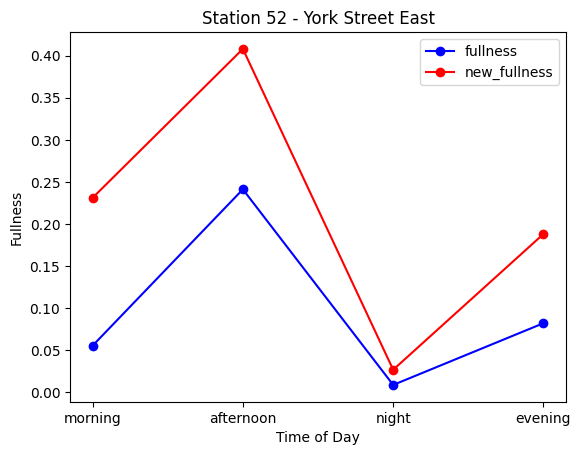

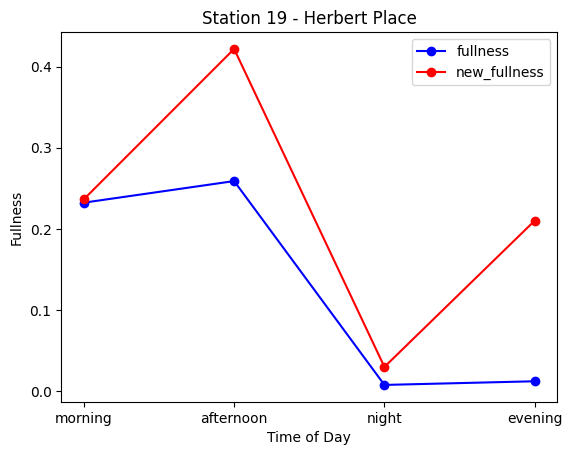

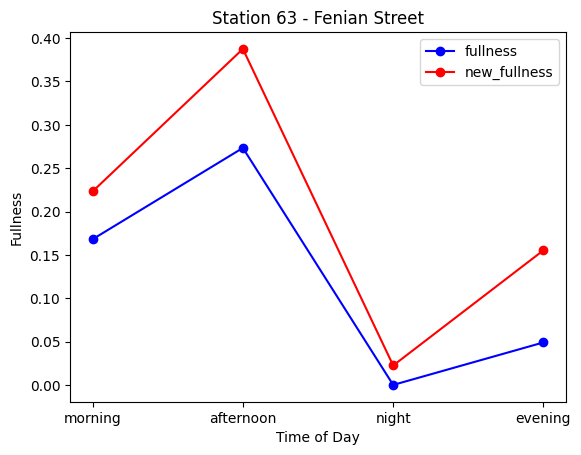

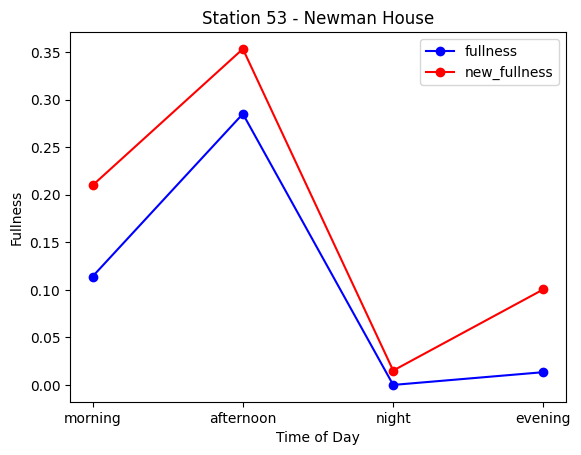

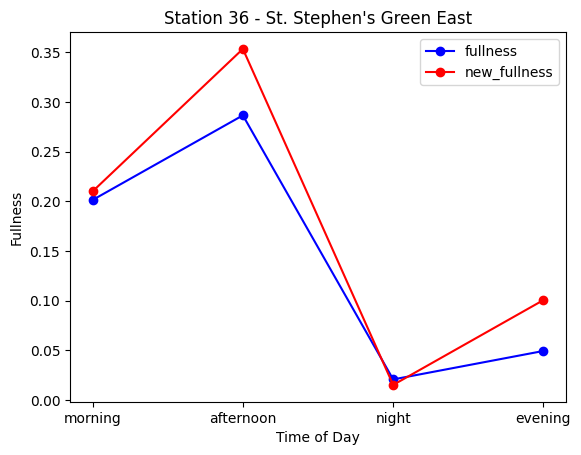

In [ ]:
for index, row in least_full.iterrows():
    plt.figure()
    plt.plot(['morning', 'afternoon', 'night', 'evening'], [row['fullness_morning'], row['fullness_afternoon'], row['fullness_night'], row['fullness_evening']], label='fullness', color='blue', marker='o')
    plt.plot(['morning', 'afternoon', 'night', 'evening'], [row['new_fullness_morning'], row['new_fullness_afternoon'], row['new_fullness_night'], row['new_fullness_evening']], label='new_fullness', color='red', marker='o')
    plt.xlabel('Time of Day')
    plt.ylabel('Fullness')
    plt.title(f'Station {row["STATION_ID"]} - {row["ADDRESS"]}')
    plt.legend()

plt.show()

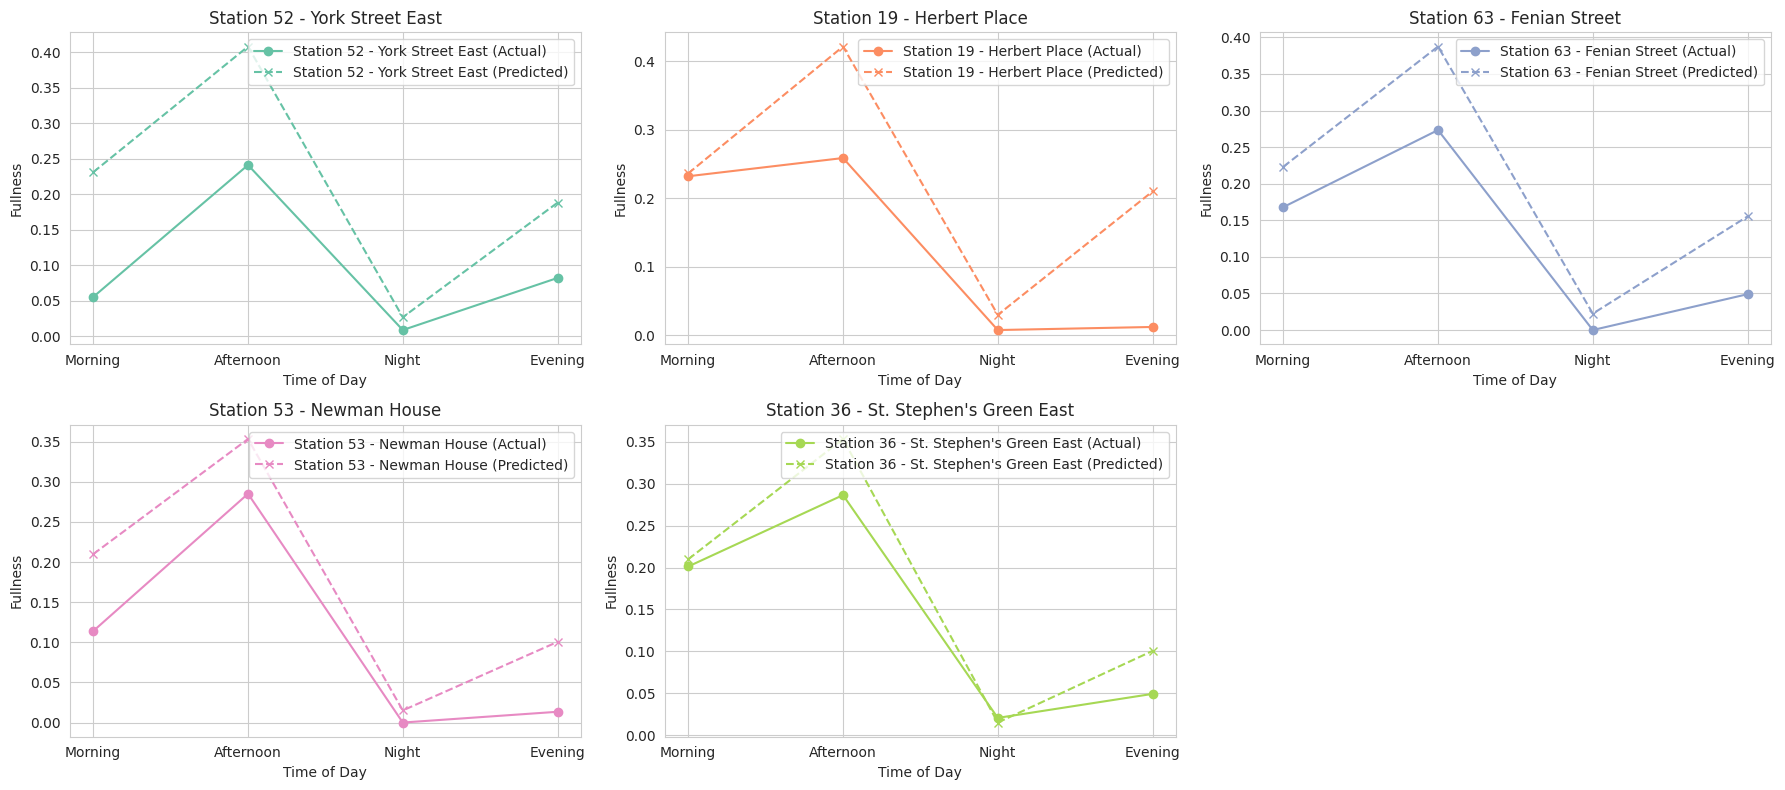

In [ ]:
import seaborn as sns

# Set a color palette for better visualization
palette = sns.color_palette("Set2")

# Create a figure and axis object for subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Plot the fullness trends for selected stations
for i, (index, row) in enumerate(least_full.iterrows()):
    color_index = i % len(palette)  # Get the color index within the palette
    axs[i].plot(['Morning', 'Afternoon', 'Night', 'Evening'],
                [row['fullness_morning'], row['fullness_afternoon'], row['fullness_night'], row['fullness_evening']],
                label=f'Station {row["STATION_ID"]} - {row["ADDRESS"]} (Actual)',
                color=palette[color_index], marker='o')
    axs[i].plot(['Morning', 'Afternoon', 'Night', 'Evening'],
                [row['new_fullness_morning'], row['new_fullness_afternoon'], row['new_fullness_night'], row['new_fullness_evening']],
                linestyle='--',
                label=f'Station {row["STATION_ID"]} - {row["ADDRESS"]} (Predicted)',
                color=palette[color_index], marker='x')  # Dashed line for predicted values

    axs[i].set_xlabel('Time of Day')
    axs[i].set_ylabel('Fullness')
    axs[i].set_title(f'Station {row["STATION_ID"]} - {row["ADDRESS"]}')
    axs[i].legend()

# Hide the remaining empty subplots
for j in range(len(least_full), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
print(least_full.columns)


Index(['fullness_afternoon', 'STATION_ID', 'BIKE_STANDS', 'fullness_whole_day',
       'fullness_morning', 'fullness_night', 'fullness_evening',
       'cluster_assignment', 'ADDRESS', 'new_stands', 'new_fullness_morning',
       'new_fullness_afternoon', 'new_fullness_evening', 'new_fullness_night'],
      dtype='object')


In [ ]:
# Get the data for each station from the data_dict dictionary
station_data = {
    "Dame Street": data_dict[0],
    "Fownes Street Upper": data_dict[0],
    "Molesworth Street": data_dict[0],
    "Merrion Square West": data_dict[0],
    "Princes Street / O'Connell Street": data_dict[0]
}

# Print the latitude and longitude for each station
for station, df in station_data.items():
    print(f"{station}: Latitude {df['LATITUDE'].iloc[0]}, Longitude {df['LONGITUDE'].iloc[0]}")


Dame Street: Latitude 53.33036, Longitude -6.265163
Fownes Street Upper: Latitude 53.33036, Longitude -6.265163
Molesworth Street: Latitude 53.33036, Longitude -6.265163
Merrion Square West: Latitude 53.33036, Longitude -6.265163
Princes Street / O'Connell Street: Latitude 53.33036, Longitude -6.265163


# 5.Plot the all the result on the map

In [ ]:
# Get the data for each station from the data_dict dictionary
station_data = {
    "York Street East": data_dict[0],
    "Herbert Place": data_dict[0],
    "Fenian Street": data_dict[0],
    "Newman House": data_dict[0],
    "St. Stephen's Green East": data_dict[0]
}

# Print the latitude and longitude for each station
for station, df in station_data.items():
    print(f"{station}: Latitude {df['LATITUDE'].iloc[0]}, Longitude {df['LONGITUDE'].iloc[0]}")


York Street East: Latitude 53.33036, Longitude -6.265163
Herbert Place: Latitude 53.33036, Longitude -6.265163
Fenian Street: Latitude 53.33036, Longitude -6.265163
Newman House: Latitude 53.33036, Longitude -6.265163
St. Stephen's Green East: Latitude 53.33036, Longitude -6.265163


In [ ]:
import folium

# Create a map centered around Dublin
map_center = [53.349805, -6.26031]
m = folium.Map(location=map_center, zoom_start=14)

# Define the stations and their locations for each group
group1_stations = {
    "Station 10 - Dame Street": (53.344365, -6.266529),
    "Station 14 - Fownes Street Upper": (53.344169, -6.263278),
    "Station 27 - Molesworth Street": (53.340786, -6.259886),
    "Station 26 - Merrion Square West": (53.339999, -6.253997),
    "Station 33 - Princes Street / O'Connell Street": (53.349558, -6.260592)
}

group2_stations = {
    "Station 52 - York Street East": (53.340705, -6.261109),
    "Station 19 - Herbert Place": (53.333296, -6.252503),
    "Station 63 - Fenian Street": (53.341332, -6.252868),
    "Station 53 - Newman House": (53.336187, -6.261319),
    "Station 36 - St. Stephen's Green East": (53.337982, -6.261316)
}

# Plot group 1 stations with red color
for name, location in group1_stations.items():
    folium.Marker(location=location, popup=name, icon=folium.Icon(color='red')).add_to(m)

# Plot group 2 stations with blue color
for name, location in group2_stations.items():
    folium.Marker(location=location, popup=name, icon=folium.Icon(color='blue')).add_to(m)

# Display the map

